# Networks Using Blocks (VGG)

## VGG Blocks

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers= []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

## VGG Network

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [5]:
def vgg(conv_arch):
    conv_blks=[]
    in_channels = 1

    for (num_conv, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_conv,in_channels,out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
       *conv_blks,
       nn.Flatten(),
       nn.Linear(out_channels*7*7, 4096),nn.ReLU(),nn.Dropout(0.5),
       nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
       nn.Linear(4096,10),
    )

In [6]:
X = torch.rand(1,1,224,224)
net = vgg(conv_arch)
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__:10}",X.shape)

Sequential torch.Size([1, 64, 112, 112])
Sequential torch.Size([1, 128, 56, 56])
Sequential torch.Size([1, 256, 28, 28])
Sequential torch.Size([1, 512, 14, 14])
Sequential torch.Size([1, 512, 7, 7])
Flatten    torch.Size([1, 25088])
Linear     torch.Size([1, 4096])
ReLU       torch.Size([1, 4096])
Dropout    torch.Size([1, 4096])
Linear     torch.Size([1, 4096])
ReLU       torch.Size([1, 4096])
Dropout    torch.Size([1, 4096])
Linear     torch.Size([1, 10])


## Training

In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)
net(torch.rand(1,1,224,224))

tensor([[ 0.0184, -0.0020,  0.0186, -0.0106,  0.0034,  0.0057, -0.0050,  0.0173,
          0.0161, -0.0050]], grad_fn=<AddmmBackward>)

loss 0.178, train acc 0.934, test acc 0.920
719.4 examples/sec on cuda:0


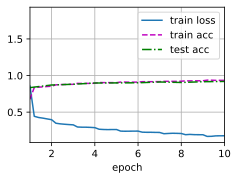

In [8]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())